In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation, Masking, Input, InputLayer, Reshape
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.python.keras import optimizers
from tensorflow.keras.optimizers import SGD

In [2]:
file_name_dataset = "RAVDESS"
dataset_ravdess_dir = "../Dataset/RAVDESS/"
ravdess_dir_list = os.listdir(dataset_ravdess_dir)

In [3]:
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [4]:
emotion_list = []
path_list = []

for dir in ravdess_dir_list:
    for audio_file in os.listdir(dataset_ravdess_dir + dir):
        emotion_segment = audio_file.split("-")[2]

        if emotion_segment in emotion_dict:
            emotion_list.append(emotion_dict[emotion_segment])
        else:
            emotion_list.append("unknown")

        audio_file_path = os.path.join(dataset_ravdess_dir, dir, audio_file)
        path_list.append(audio_file_path)

ravdess_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
ravdess_df.to_csv("tess_df.csv", index = False)
ravdess_df.head()

,Emotion,Path
0,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-01-...
1,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-02-...
2,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-01-...
3,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-02-...
4,calm,../Dataset/RAVDESS/Actor_01\03-01-02-01-01-01-...


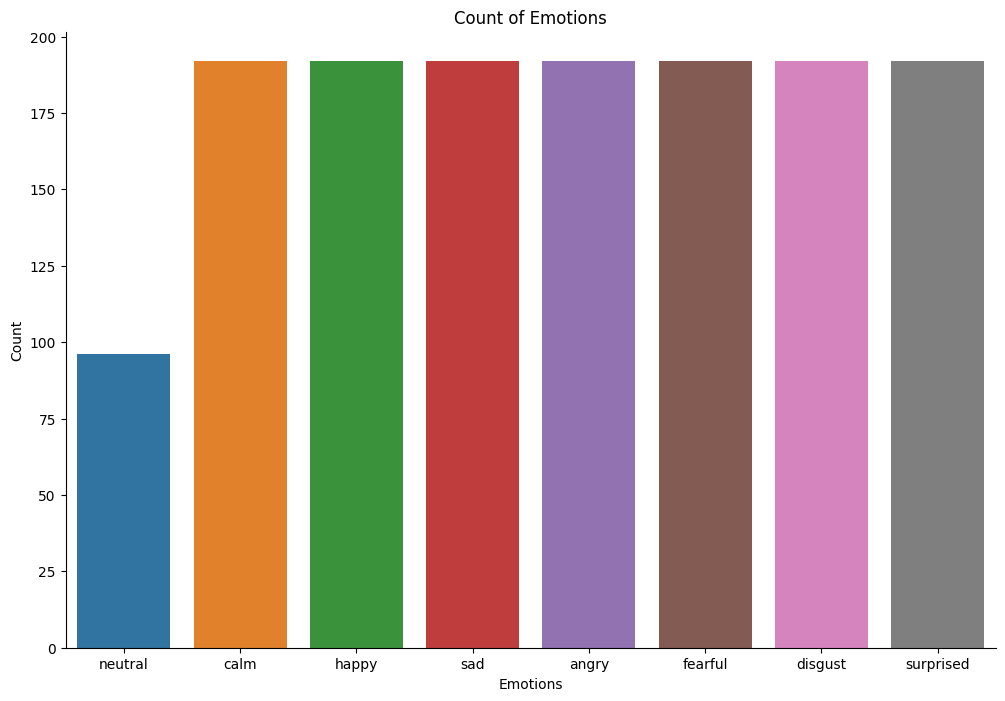

In [5]:
plt.figure(figsize=(12, 8))
plt.title('Count of Emotions')
sns.countplot(x = ravdess_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [6]:
def noise(data):
  noise_amp = 0.04 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [7]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

In [8]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
# feature_extraction_techniques = ["MFCC Mean 40", "Delta MFCC Mean 40", "Delta Delta MFCC Mean 40"]
feature_extraction_techniques = ["MFCC Mean 40"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr, n_mfcc=40):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, n_mfcc).T
    delta_mfcc = extract_delta_mfcc(data, sr, n_mfcc).T
    delta_delta_mfcc = extract_delta_delta_mfcc(data, sr, n_mfcc).T
    mfcc_mean = np.mean(mfcc, axis=0)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=0)
    delta_delta_mfcc_mean = np.mean(delta_delta_mfcc, axis=0)
    # mfcc_min = np.min(mfcc, axis=0)
    # mfcc_max = np.max(mfcc, axis=0)
    # mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [9]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
# data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "Stretched 0.7", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]
data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]

file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.75) #Ignore this
    stretched_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.7) #Ignore this
    shift_data = shift(data, (-5, 5)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    stretched_features = extract_features(stretched_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [10]:
filename = file_name_dataset + " # " + file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [11]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(ravdess_df)

df.head()

,Emotion,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,neutral,-670.195435,65.063850,0.888954,14.715979,9.182164,0.660575,-3.846836,-3.583946,-12.959006,...,-2.351098,-2.504727,-3.151507,-2.190899,-3.801760,-1.813088,-1.261222,-2.144954,-4.152173,-1.779615
1,neutral,-437.411376,24.860678,7.356011,8.004017,5.143942,0.050777,-3.462119,-6.175004,-7.927267,...,-0.913083,-1.325904,-1.392386,-1.818780,-1.903436,-0.807370,-0.963922,-1.762706,-2.651064,-2.611878
2,neutral,-691.445679,62.221443,-0.300504,14.352509,8.497726,0.746647,-4.348557,-4.798969,-14.069670,...,-2.381158,-2.261819,-2.873888,-1.883212,-4.045451,-1.785669,-1.113154,-2.164787,-4.364875,-1.768830
3,neutral,-712.516907,66.194984,1.424330,16.236750,9.380598,1.506902,-4.124938,-3.517112,-13.283334,...,-1.922169,-2.280859,-3.436191,-1.829611,-4.056078,-1.664588,-0.654646,-1.566690,-4.341530,-1.645019
4,neutral,-697.627258,62.472347,-1.029173,15.987646,7.447986,-0.467146,-5.220094,-5.383532,-13.847498,...,-4.750515,-3.052244,-4.137149,-2.542254,-3.379075,-0.843549,-2.677613,-4.869622,-3.312335,-3.609416


In [12]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [13]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [14]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=True)

In [15]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((6912, 40), (6912, 8), (864, 40), (864, 8), (864, 40), (864, 8))

In [16]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
X_validation = x_validation.reshape(x_validation.shape[0] , x_validation.shape[1] , 1)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((6912, 40, 1), (6912, 8), (864, 40, 1), (864, 8), (864, 40, 1), (864, 8))

In [17]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [18]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [19]:
def simplify_label(label):
    if 'angry' in label:
        return 'angry'
    elif 'disgust' in label:
        return 'disgust'
    elif 'fear' in label:
        return 'fear'
    elif 'happy' in label:
        return 'happy'
    elif 'sad' in label:
        return 'sad'
    elif 'surprise' in label:
        return 'surprise'
    elif 'neutral' in label:
        return 'neutral'
    else:
        return label

In [20]:
def create_model_summary(model_type):
    test_prediction = model_type.predict(X_test)

    prediction_actual_df = pd.DataFrame({
    'Predicted': encoder.inverse_transform(test_prediction).flatten(),
    'Actual': encoder.inverse_transform(y_test).flatten()
    })

    prediction_actual_df.head()

    modified_df = prediction_actual_df.copy()
    modified_df['Actual'] = modified_df['Actual'].apply(simplify_label)
    modified_df['Predicted'] = modified_df['Predicted'].apply(simplify_label)

    res_mat = confusion_matrix(modified_df['Actual'], modified_df['Predicted'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(res_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=modified_df['Predicted'].unique(), 
                yticklabels=modified_df['Actual'].unique())
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(modified_df['Actual'], modified_df['Predicted']))

    accuracy = accuracy_score(modified_df['Actual'], modified_df['Predicted'])
    print(f"Accuracy: {round(accuracy * 100, 2)}%")

In [21]:
resnet50_weights_path = '../ResNet/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet101_weights_path = '../ResNet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet152_weights_path = '../ResNet/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [22]:
def create_resnet_model(model_type, epochs, filename):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    input_layer = Input(shape=input_shape)

    model_map = {
        'EfficientNetB0': EfficientNetB0,
        'EfficientNetB1': EfficientNetB1,
        'EfficientNetB2': EfficientNetB2,
        'EfficientNetB3': EfficientNetB3,
        'EfficientNetB4': EfficientNetB4,
        'EfficientNetB5': EfficientNetB5,
        'EfficientNetB6': EfficientNetB6,
        'EfficientNetB7': EfficientNetB7,
        'EfficientNetV2B0': EfficientNetV2B0,
        'EfficientNetV2B1': EfficientNetV2B1,
        'EfficientNetV2B2': EfficientNetV2B2,
        'EfficientNetV2B3': EfficientNetV2B3,
        'EfficientNetV2S': EfficientNetV2S,
        'EfficientNetV2M': EfficientNetV2M,
        'EfficientNetV2L': EfficientNetV2L
    }

    if model_type not in model_map:
        raise ValueError("Invalid model_type provided. Please choose from EfficientNetB0, B1, B2, B3, B4, B5, B6, B7, V2B0, V2B1, V2B2, V2B3, V2S, V2M, V2L.")

    base_model = model_map[model_type](weights=None, include_top=False, input_tensor=input_layer, pooling='avg')

    x = base_model.output
    output_layer = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.summary()
    
    sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.00001)
    checkpoint = ModelCheckpoint(filepath=filename + '_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[reduce_lr, early_stop, checkpoint]
    )
    
    return model, history

Training model: EfficientNetB0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1, 1)]   0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 40, 1, 1)     0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 40, 1, 1)     3           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 41, 3, 1)     0           ['normalization[0][0]']          
                                                               

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.1375 - accuracy: 0.2270
Epoch 1: val_accuracy improved from -inf to 0.13542, saving model to RAVDESS EfficientNetB0_best.h5
216/216 [==============================] - 30s 89ms/step - loss: 2.1375 - accuracy: 0.2270 - val_loss: 2.0641 - val_accuracy: 0.1354 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.8114 - accuracy: 0.3192
Epoch 2: val_accuracy improved from 0.13542 to 0.15278, saving model to RAVDESS EfficientNetB0_best.h5
216/216 [==============================] - 17s 81ms/step - loss: 1.8114 - accuracy: 0.3192 - val_loss: 2.1700 - val_accuracy: 0.1528 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 1.5873 - accuracy: 0.4006
Epoch 3: val_accuracy improved from 0.15278 to 0.23495, saving model to RAVDESS EfficientNetB0_best.h5
216/216 [==============================] - 17s 80ms/step - loss: 1.5873 - accuracy: 0.4006 - val_loss: 2.1241 - val_accuracy:

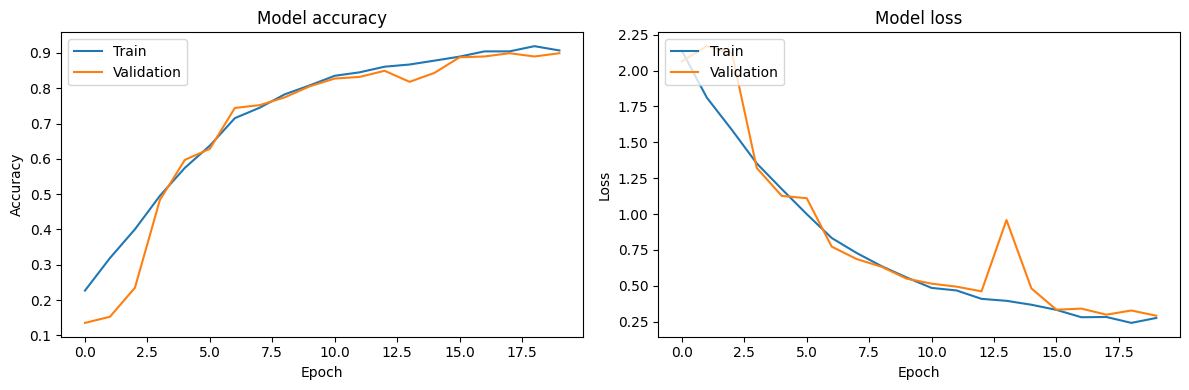

27/27 [==============================] - 2s 20ms/step


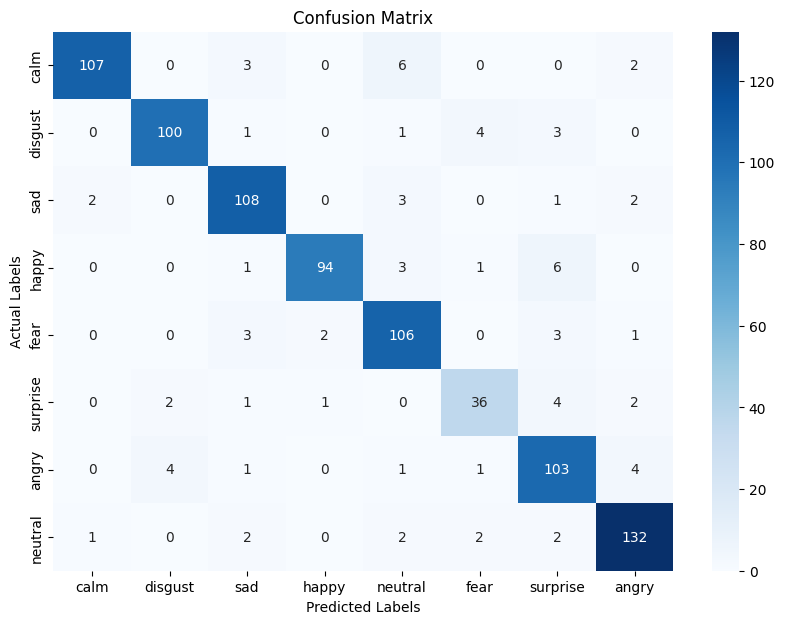

              precision    recall  f1-score   support

       angry       0.97      0.91      0.94       118
        calm       0.94      0.92      0.93       109
     disgust       0.90      0.93      0.92       116
        fear       0.97      0.90      0.93       105
       happy       0.87      0.92      0.89       115
     neutral       0.82      0.78      0.80        46
         sad       0.84      0.90      0.87       114
    surprise       0.92      0.94      0.93       141

    accuracy                           0.91       864
   macro avg       0.90      0.90      0.90       864
weighted avg       0.91      0.91      0.91       864

Accuracy: 90.97%
Training model: EfficientNetB1
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.2288 - accuracy: 0.1965
Epoch 1: val_accuracy improved from -inf to 0.13773, saving model to RAVDESS EfficientNetB1_best.h5
216/216 [==============================] - 38s 128ms/step - loss: 2.2288 - accuracy: 0.1965 - val_loss: 2.0605 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.9350 - accuracy: 0.2776
Epoch 2: val_accuracy did not improve from 0.13773
216/216 [==============================] - 24s 110ms/step - loss: 1.9350 - accuracy: 0.2776 - val_loss: 2.0778 - val_accuracy: 0.1273 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 1.7515 - accuracy: 0.3424
Epoch 3: val_accuracy improved from 0.13773 to 0.24190, saving model to RAVDESS EfficientNetB1_best.h5
216/216 [==============================] - 25s 114ms/step - loss: 1.7515 - accuracy: 0.3424 - val_loss: 1.8742 - val_accuracy: 0.2419 - lr: 0.0100
Epoch 4/20
216/216 [========

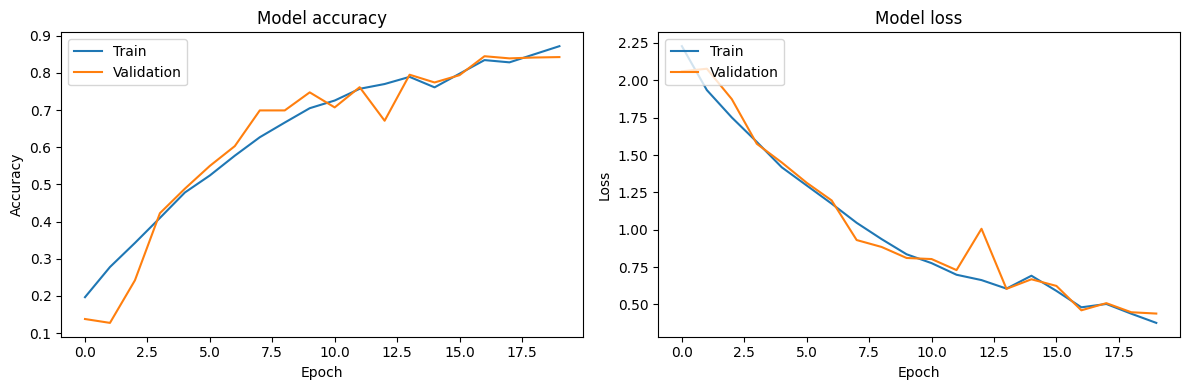

27/27 [==============================] - 2s 25ms/step


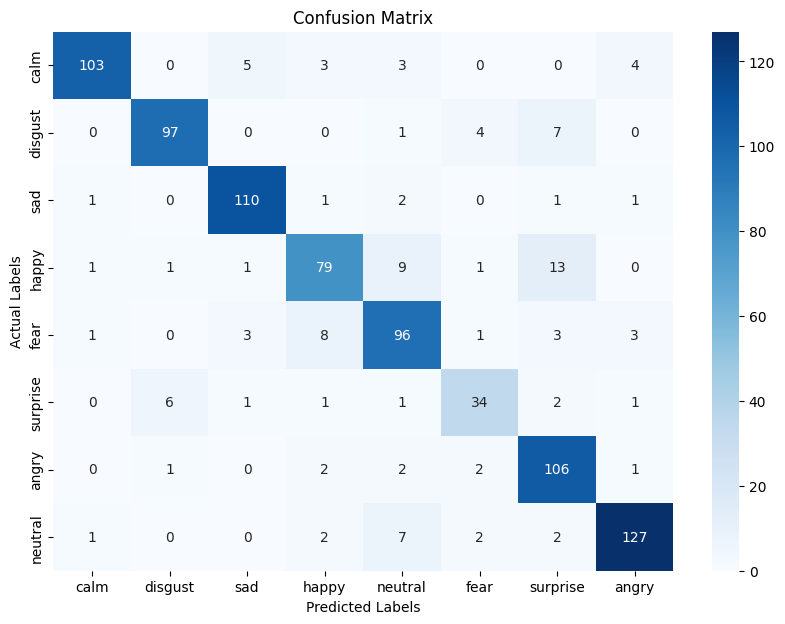

              precision    recall  f1-score   support

       angry       0.96      0.87      0.92       118
        calm       0.92      0.89      0.91       109
     disgust       0.92      0.95      0.93       116
        fear       0.82      0.75      0.79       105
       happy       0.79      0.83      0.81       115
     neutral       0.77      0.74      0.76        46
         sad       0.79      0.93      0.85       114
    surprise       0.93      0.90      0.91       141

    accuracy                           0.87       864
   macro avg       0.86      0.86      0.86       864
weighted avg       0.87      0.87      0.87       864

Accuracy: 87.04%
Training model: EfficientNetB2
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.2179 - accuracy: 0.1968
Epoch 1: val_accuracy improved from -inf to 0.15278, saving model to RAVDESS EfficientNetB2_best.h5
216/216 [==============================] - 39s 117ms/step - loss: 2.2179 - accuracy: 0.1968 - val_loss: 2.0612 - val_accuracy: 0.1528 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.9551 - accuracy: 0.2784
Epoch 2: val_accuracy did not improve from 0.15278
216/216 [==============================] - 23s 105ms/step - loss: 1.9551 - accuracy: 0.2784 - val_loss: 2.0851 - val_accuracy: 0.1447 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 1.7700 - accuracy: 0.3322
Epoch 3: val_accuracy improved from 0.15278 to 0.21991, saving model to RAVDESS EfficientNetB2_best.h5
216/216 [==============================] - 24s 109ms/step - loss: 1.7700 - accuracy: 0.3322 - val_loss: 2.0123 - val_accuracy: 0.2199 - lr: 0.0100
Epoch 4/20
216/216 [========

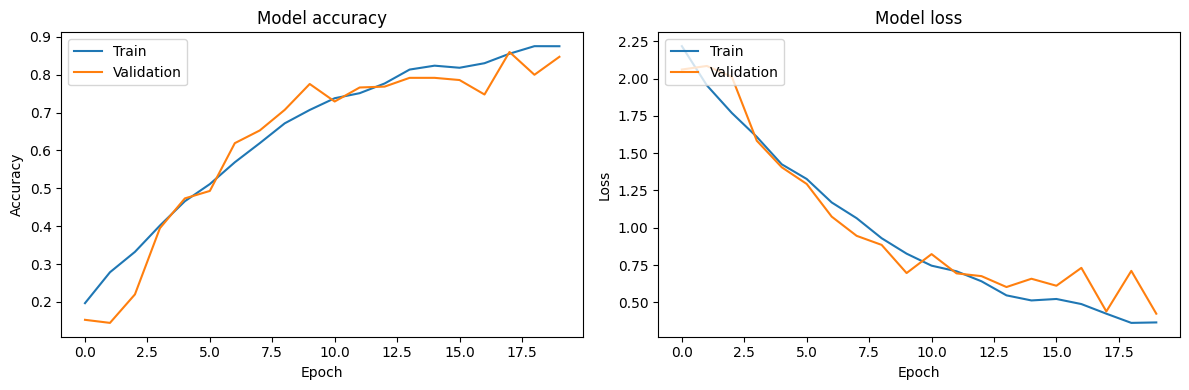

27/27 [==============================] - 2s 29ms/step


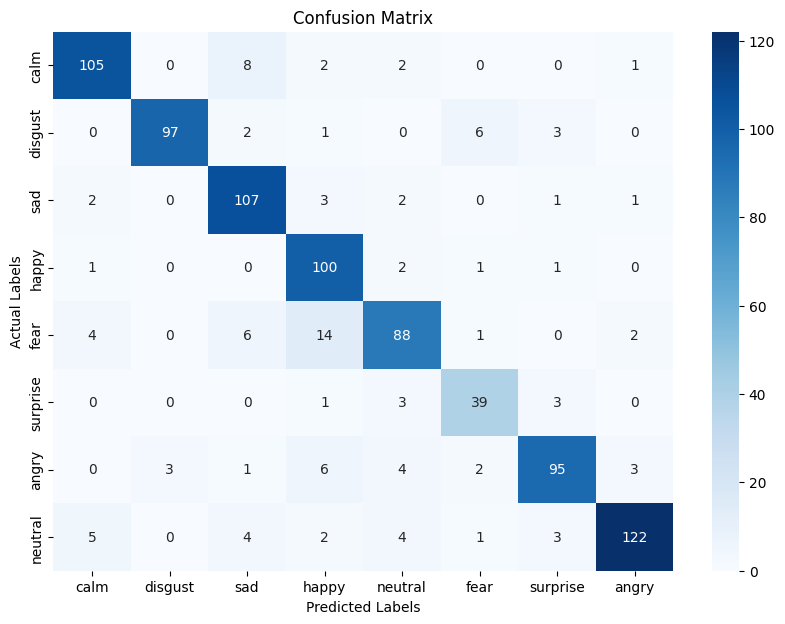

              precision    recall  f1-score   support

       angry       0.90      0.89      0.89       118
        calm       0.97      0.89      0.93       109
     disgust       0.84      0.92      0.88       116
        fear       0.78      0.95      0.85       105
       happy       0.84      0.77      0.80       115
     neutral       0.78      0.85      0.81        46
         sad       0.90      0.83      0.86       114
    surprise       0.95      0.87      0.90       141

    accuracy                           0.87       864
   macro avg       0.87      0.87      0.87       864
weighted avg       0.88      0.87      0.87       864

Accuracy: 87.15%
Training model: EfficientNetB3
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.2704 - accuracy: 0.1920
Epoch 1: val_accuracy improved from -inf to 0.15278, saving model to RAVDESS EfficientNetB3_best.h5
216/216 [==============================] - 43s 138ms/step - loss: 2.2704 - accuracy: 0.1920 - val_loss: 2.0806 - val_accuracy: 0.1528 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.8946 - accuracy: 0.3024
Epoch 2: val_accuracy did not improve from 0.15278
216/216 [==============================] - 26s 121ms/step - loss: 1.8946 - accuracy: 0.3024 - val_loss: 2.0898 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 1.7003 - accuracy: 0.3678
Epoch 3: val_accuracy improved from 0.15278 to 0.17361, saving model to RAVDESS EfficientNetB3_best.h5
216/216 [==============================] - 27s 125ms/step - loss: 1.7003 - accuracy: 0.3678 - val_loss: 2.0313 - val_accuracy: 0.1736 - lr: 0.0100
Epoch 4/20
216/216 [========

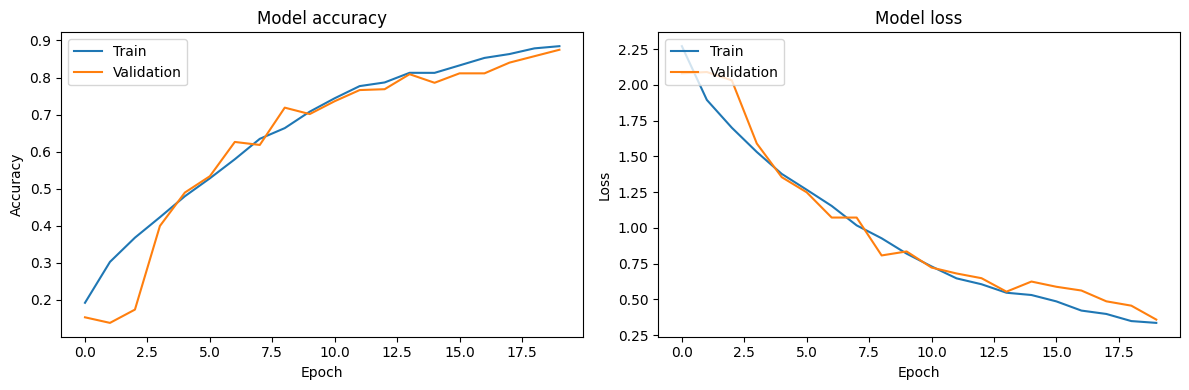

27/27 [==============================] - 3s 29ms/step


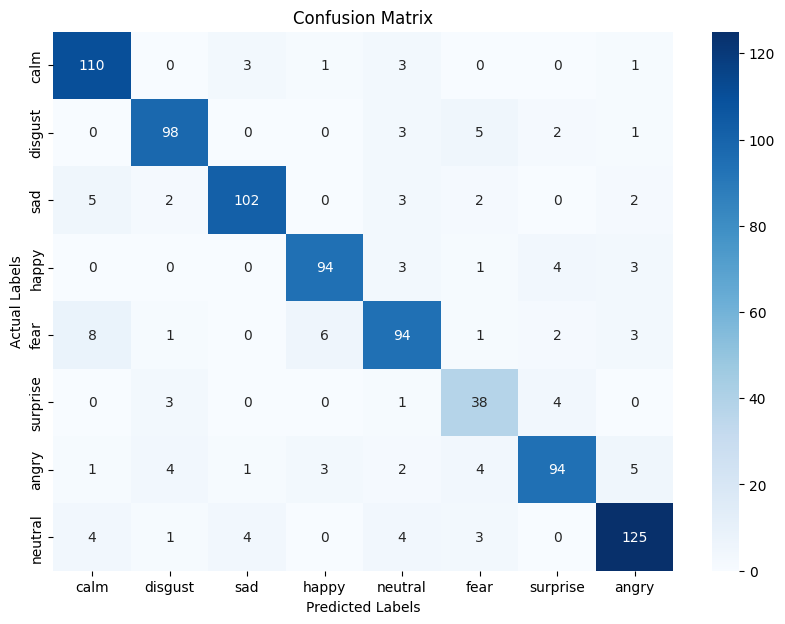

              precision    recall  f1-score   support

       angry       0.86      0.93      0.89       118
        calm       0.90      0.90      0.90       109
     disgust       0.93      0.88      0.90       116
        fear       0.90      0.90      0.90       105
       happy       0.83      0.82      0.82       115
     neutral       0.70      0.83      0.76        46
         sad       0.89      0.82      0.85       114
    surprise       0.89      0.89      0.89       141

    accuracy                           0.87       864
   macro avg       0.86      0.87      0.87       864
weighted avg       0.88      0.87      0.87       864

Accuracy: 87.38%
Training model: EfficientNetB4
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.3156 - accuracy: 0.1758
Epoch 1: val_accuracy improved from -inf to 0.13773, saving model to RAVDESS EfficientNetB4_best.h5
216/216 [==============================] - 56s 180ms/step - loss: 2.3156 - accuracy: 0.1758 - val_loss: 2.0690 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.9408 - accuracy: 0.2620
Epoch 2: val_accuracy did not improve from 0.13773
216/216 [==============================] - 35s 161ms/step - loss: 1.9408 - accuracy: 0.2620 - val_loss: 2.1065 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 1.7921 - accuracy: 0.3205
Epoch 3: val_accuracy improved from 0.13773 to 0.18171, saving model to RAVDESS EfficientNetB4_best.h5
216/216 [==============================] - 38s 174ms/step - loss: 1.7921 - accuracy: 0.3205 - val_loss: 2.0079 - val_accuracy: 0.1817 - lr: 0.0100
Epoch 4/20
216/216 [========

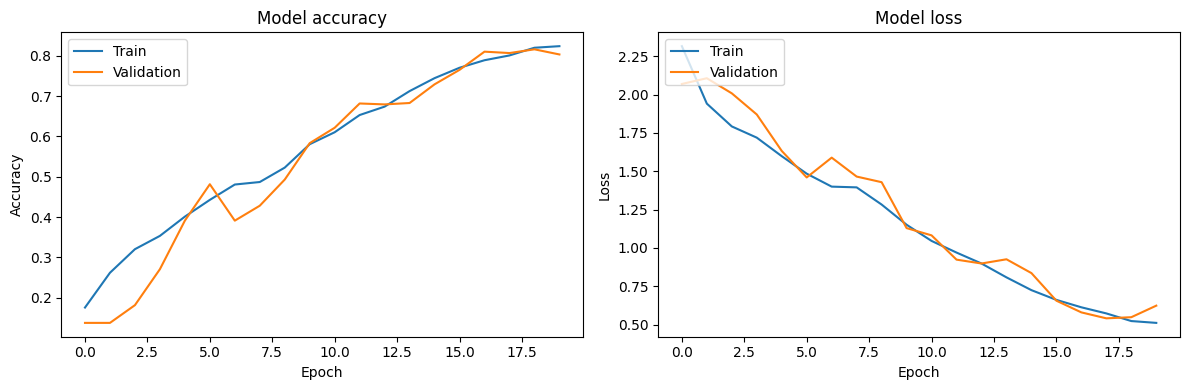

27/27 [==============================] - 3s 35ms/step


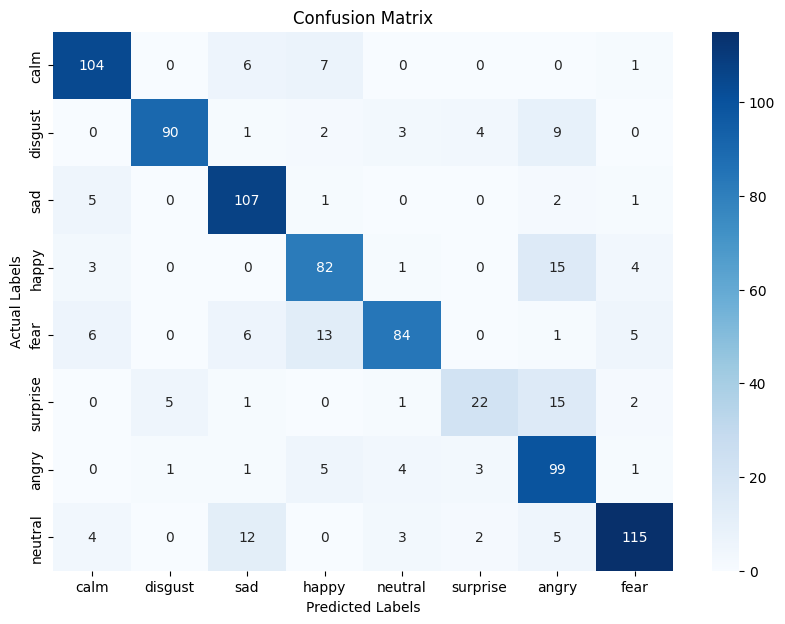

              precision    recall  f1-score   support

       angry       0.85      0.88      0.87       118
        calm       0.94      0.83      0.88       109
     disgust       0.80      0.92      0.86       116
        fear       0.75      0.78      0.76       105
       happy       0.88      0.73      0.80       115
     neutral       0.71      0.48      0.57        46
         sad       0.68      0.87      0.76       114
    surprise       0.89      0.82      0.85       141

    accuracy                           0.81       864
   macro avg       0.81      0.79      0.79       864
weighted avg       0.82      0.81      0.81       864

Accuracy: 81.37%
Training model: EfficientNetB5
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.4139 - accuracy: 0.1432
Epoch 1: val_accuracy improved from -inf to 0.13542, saving model to RAVDESS EfficientNetB5_best.h5
216/216 [==============================] - 75s 245ms/step - loss: 2.4139 - accuracy: 0.1432 - val_loss: 2.0598 - val_accuracy: 0.1354 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 2.1322 - accuracy: 0.1386
Epoch 2: val_accuracy did not improve from 0.13542
216/216 [==============================] - 47s 215ms/step - loss: 2.1322 - accuracy: 0.1386 - val_loss: 2.0710 - val_accuracy: 0.1273 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 2.0805 - accuracy: 0.1526
Epoch 3: val_accuracy improved from 0.13542 to 0.16435, saving model to RAVDESS EfficientNetB5_best.h5
216/216 [==============================] - 47s 220ms/step - loss: 2.0805 - accuracy: 0.1526 - val_loss: 2.0902 - val_accuracy: 0.1644 - lr: 0.0100
Epoch 4/20
216/216 [========

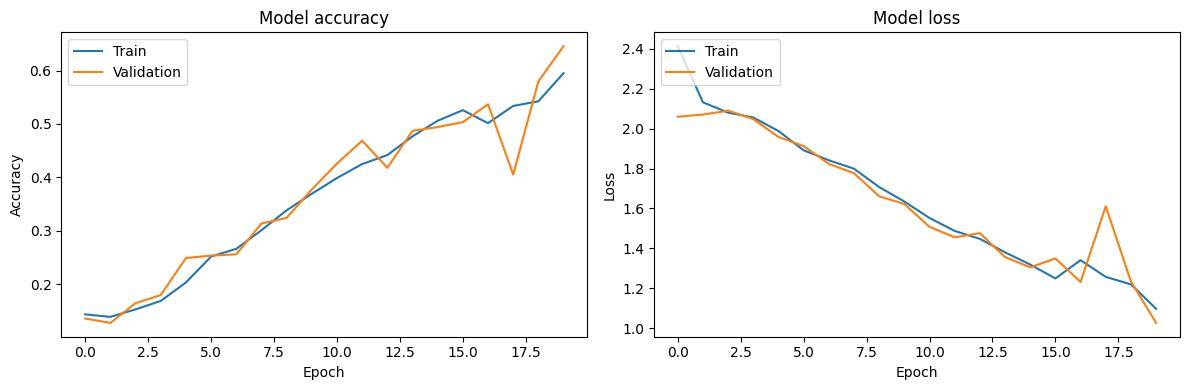

27/27 [==============================] - 5s 50ms/step


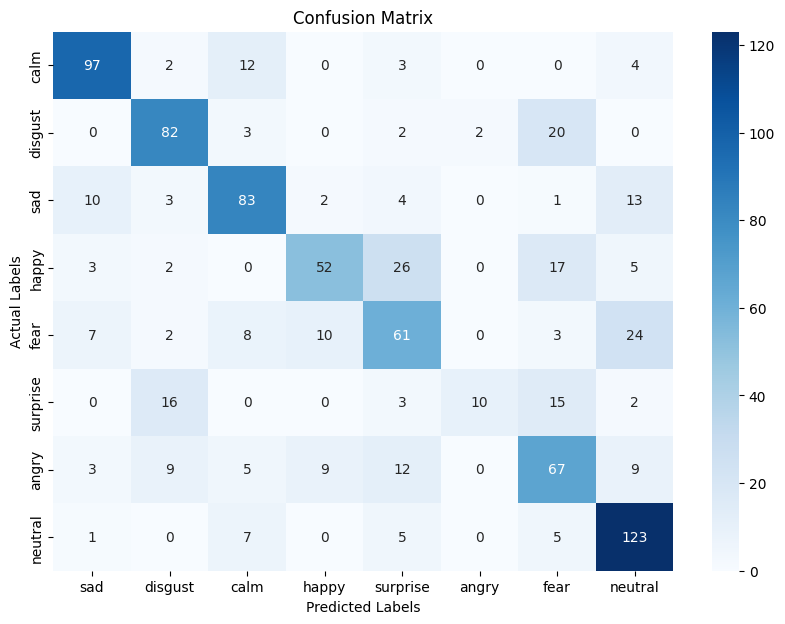

              precision    recall  f1-score   support

       angry       0.80      0.82      0.81       118
        calm       0.71      0.75      0.73       109
     disgust       0.70      0.72      0.71       116
        fear       0.71      0.50      0.58       105
       happy       0.53      0.53      0.53       115
     neutral       0.83      0.22      0.34        46
         sad       0.52      0.59      0.55       114
    surprise       0.68      0.87      0.77       141

    accuracy                           0.67       864
   macro avg       0.69      0.62      0.63       864
weighted avg       0.67      0.67      0.66       864

Accuracy: 66.55%
Training model: EfficientNetB6
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.4909 - accuracy: 0.1374
Epoch 1: val_accuracy improved from -inf to 0.12384, saving model to RAVDESS EfficientNetB6_best.h5
216/216 [==============================] - 96s 329ms/step - loss: 2.4909 - accuracy: 0.1374 - val_loss: 2.0806 - val_accuracy: 0.1238 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 2.1483 - accuracy: 0.1457
Epoch 2: val_accuracy improved from 0.12384 to 0.13542, saving model to RAVDESS EfficientNetB6_best.h5
216/216 [==============================] - 65s 298ms/step - loss: 2.1483 - accuracy: 0.1457 - val_loss: 2.0702 - val_accuracy: 0.1354 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 2.0915 - accuracy: 0.1447
Epoch 3: val_accuracy improved from 0.13542 to 0.15625, saving model to RAVDESS EfficientNetB6_best.h5
216/216 [==============================] - 64s 297ms/step - loss: 2.0915 - accuracy: 0.1447 - val_loss: 2.0751 - val_accura

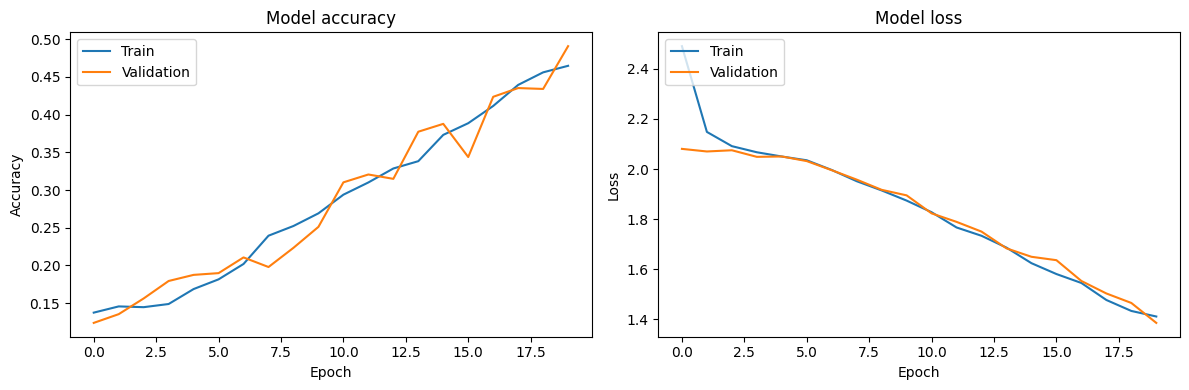

27/27 [==============================] - 7s 63ms/step


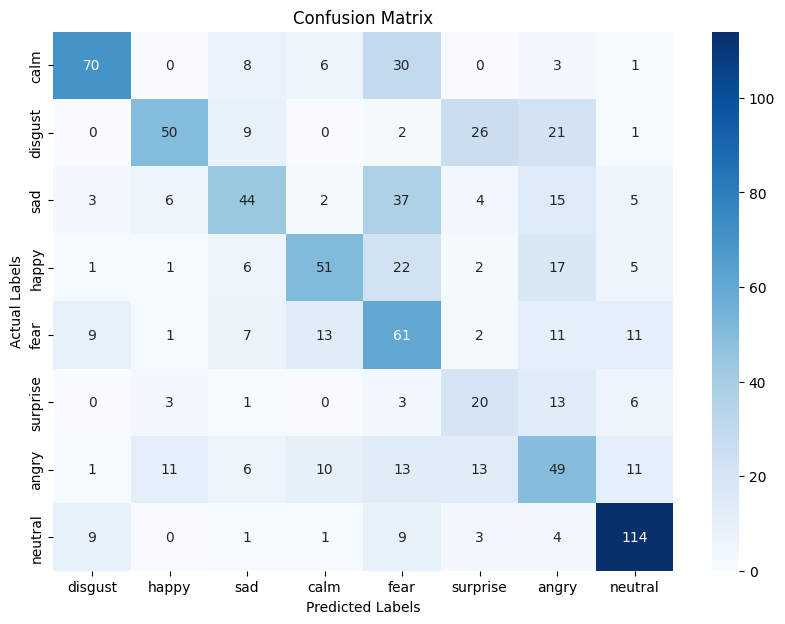

              precision    recall  f1-score   support

       angry       0.75      0.59      0.66       118
        calm       0.69      0.46      0.55       109
     disgust       0.54      0.38      0.44       116
        fear       0.61      0.49      0.54       105
       happy       0.34      0.53      0.42       115
     neutral       0.29      0.43      0.34        46
         sad       0.37      0.43      0.40       114
    surprise       0.74      0.81      0.77       141

    accuracy                           0.53       864
   macro avg       0.54      0.52      0.52       864
weighted avg       0.57      0.53      0.54       864

Accuracy: 53.12%
Training model: EfficientNetB7
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.5060 - accuracy: 0.1366
Epoch 1: val_accuracy improved from -inf to 0.09259, saving model to RAVDESS EfficientNetB7_best.h5
216/216 [==============================] - 116s 405ms/step - loss: 2.5060 - accuracy: 0.1366 - val_loss: 4.3280 - val_accuracy: 0.0926 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 2.1146 - accuracy: 0.1512
Epoch 2: val_accuracy improved from 0.09259 to 0.14352, saving model to RAVDESS EfficientNetB7_best.h5
216/216 [==============================] - 84s 387ms/step - loss: 2.1146 - accuracy: 0.1512 - val_loss: 2.0565 - val_accuracy: 0.1435 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 2.0681 - accuracy: 0.1613
Epoch 3: val_accuracy improved from 0.14352 to 0.15394, saving model to RAVDESS EfficientNetB7_best.h5
216/216 [==============================] - 89s 412ms/step - loss: 2.0681 - accuracy: 0.1613 - val_loss: 2.0387 - val_accur

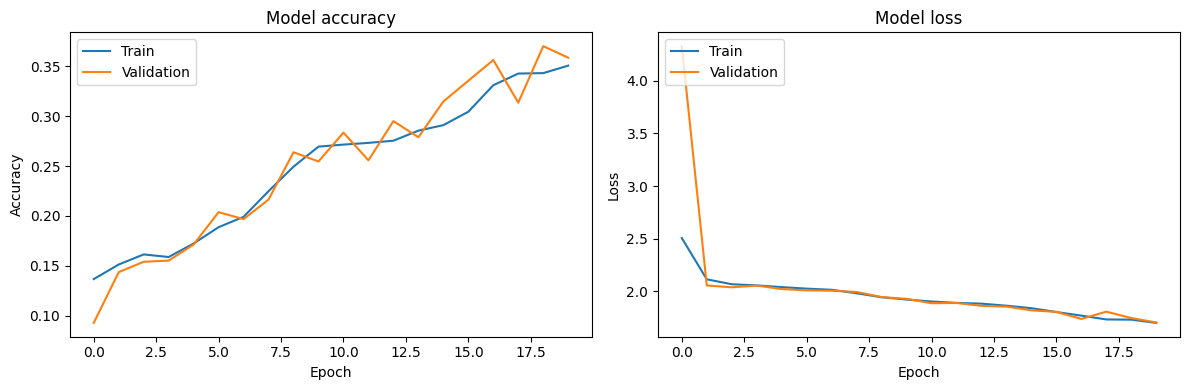

27/27 [==============================] - 8s 92ms/step


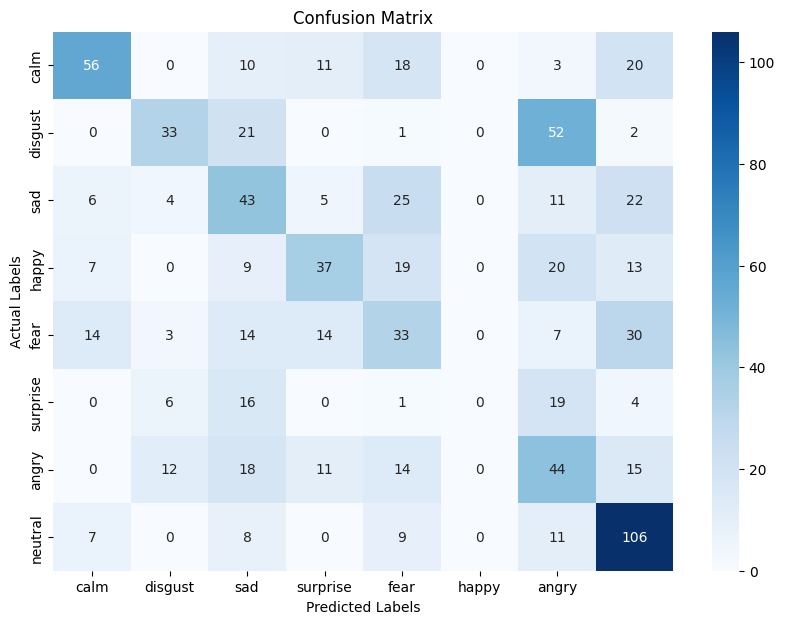

              precision    recall  f1-score   support

       angry       0.62      0.47      0.54       118
        calm       0.57      0.30      0.40       109
     disgust       0.31      0.37      0.34       116
        fear       0.47      0.35      0.40       105
       happy       0.28      0.29      0.28       115
     neutral       0.00      0.00      0.00        46
         sad       0.26      0.39      0.31       114
    surprise       0.50      0.75      0.60       141

    accuracy                           0.41       864
   macro avg       0.38      0.37      0.36       864
weighted avg       0.41      0.41      0.39       864

Accuracy: 40.74%


c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [23]:
# model_types = [
#     'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 
#     'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7',
#     'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3',
#     'EfficientNetV2S', 'EfficientNetV2M', 'EfficientNetV2L'
# ]

model_types = [
    'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 
    'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7'
]

for model_type in model_types:
    print(f"Training model: {model_type}")
    model, history = create_resnet_model(model_type, 20, 'RAVDESS ' + model_type)
    evaluate_model(model)
    plot_history(history)
    create_model_summary(model)